In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from app.models import Session, Article, Headline, Agency
from sqlalchemy import func

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mas/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mas/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
session = Session()

In [3]:
articles = session.query(Article).join(Headline).group_by(Article.id).having(func.count(Headline.id) >= 3).all()

In [4]:
len(articles)

615

In [5]:
articles[0].headlines

[Headline(id=65, agency='Breitbart', title='Fani Willis Allegedly Reimbursed Her Lover and Fellow Trump Prosecutor'),
 Headline(id=744, agency='Breitbart', title='…BF Says She Reimbursed Her for Trips — with Cash'),
 Headline(id=3812, agency='Breitbart', title='…BF Says She Reimbursed Him for Trips — with Cash…')]

In [6]:
articles = list(sorted(articles, key=lambda x: len(x.headlines), reverse=True))

In [7]:
articles[0].headlines

[Headline(id=3902, agency='CBS News', title='Watch Live: Fulton County D.A. Fani Willis will not return to the stand Fulton County prosecutors will not call D.A. Fani Willis to testify for a second day in the hearing held to disqualify her from prosecuting the Georgia election interference case against Donald Trump. updated 3M ago'),
 Headline(id=4721, agency='CBS News', title='Fulton County D.A. Fani Willis will not return to the stand Fulton County prosecutors will not call D.A. Fani Willis to testify for a second day in the hearing held to disqualify her from prosecuting the Georgia election interference case against Donald Trump. updated 7M ago'),
 Headline(id=5306, agency='CBS News', title='Fulton County D.A. Fani Willis will not return to the stand Fulton County prosecutors will not call D.A. Fani Willis to testify for a second day in the hearing held to disqualify her from prosecuting the Georgia election interference case against Donald Trump. updated 10M ago'),
 Headline(id=53

In [8]:
article = articles[0]

In [9]:
df = pd.DataFrame([{'sentiment': h.headcompound, 'time': h.last_accessed} for h in article.headlines])

AttributeError: 'Headline' object has no attribute 'headcompound'

In [10]:
df

NameError: name 'df' is not defined

In [11]:
sns.lineplot(x='time', y='sentiment', data=df)

NameError: name 'df' is not defined

In [12]:
changes = []
for article in articles:
    df = pd.DataFrame([{'title': h.title, 'sentiment': h.headcompound, 'time': h.last_accessed} for h in article.headlines])
    if df.sentiment.nunique() > 1:
        changes.append(df)

AttributeError: 'Headline' object has no attribute 'headcompound'

In [13]:
import matplotlib.dates as mdates
sns.lineplot(x='time', y='sentiment', data=changes[0])
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.xticks(rotation=45)
plt.show()

IndexError: list index out of range

In [29]:
s = session

In [52]:
data = s.query(Headline.comp, Headline.last_accessed, Agency._bias)\
    .join(Headline.article).join(Article.agency).all()
df = pd.DataFrame(data, columns=['Sentiment', 'Last Accessed', 'Bias'])
df['Date'] = pd.to_datetime(df['Last Accessed'])
df['PSI'] = df['Sentiment'] * df['Bias']
agg = df.set_index('Date').groupby(pd.Grouper(freq='D'))\
    .agg({'Sentiment': ['mean', 'median'], 'PSI': 'mean'}).dropna().reset_index()
agg.columns = [' '.join(col).strip() for col in agg.columns.values]
agg

,Date,Sentiment mean,Sentiment median,PSI mean
0,2024-02-15,-0.035788,0.0,0.068551
1,2024-02-16,-0.094683,0.0,0.012225
2,2024-02-17,-0.081589,0.0,0.012311
3,2024-02-19,-0.025441,0.0,0.013926


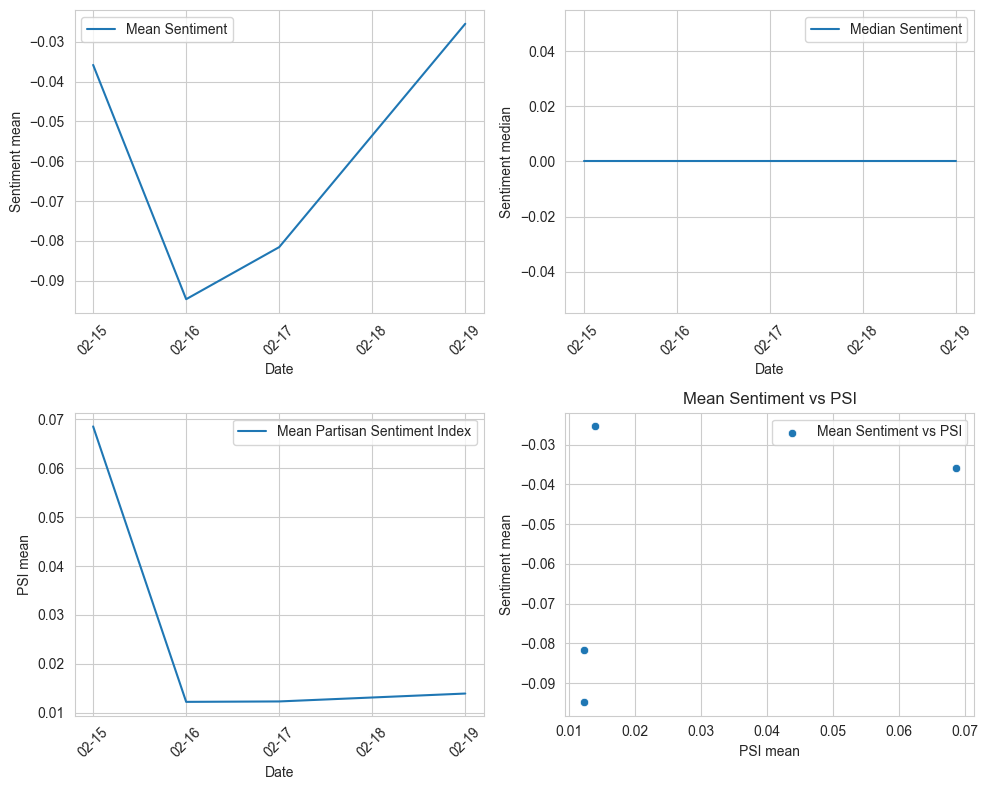

In [60]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(10, 8)
sns.lineplot(x='Date', y='Sentiment mean', data=agg, ax=ax[0, 0], label='Mean Sentiment')
sns.lineplot(x='Date', y='Sentiment median', data=agg, ax=ax[0, 1], label='Median Sentiment')
sns.lineplot(x='Date', y='PSI mean', data=agg, ax=ax[1, 0], label='Mean Partisan Sentiment Index')
sns.scatterplot(x='PSI mean', y='Sentiment mean', data=agg, ax=ax[1, 1], label='Mean Sentiment vs PSI')
for i in range(2):
    for j in range(2):
        if i == 1 and j == 1:
            continue
        ax[i, j].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax[i, j].set_xticks(ax[i, j].get_xticks()[::2])
        ax[i, j].set_xticklabels(ax[i, j].get_xticklabels(), rotation=45)
ax[1, 1].set_title('Mean Sentiment vs PSI')
plt.tight_layout()

In [85]:
subq = session.query(Headline.article_id).join(Article).group_by(Headline.article_id).having(func.count(Headline.id) > 3).subquery()
data = s.query(Headline.last_accessed, Headline.comp, Headline.title, Article.url, Agency.name).join(Headline.article).join(Article.agency).filter(Article.id.in_(subq)).order_by(Headline.last_accessed).all()
df = pd.DataFrame(data, columns=['Date', 'Sentiment', 'Title', 'URL', 'Agency'])
df

/var/folders/fd/vfz6tp5d6lg2p2jkv89sf3jm0000gn/T/ipykernel_46856/4229047846.py:2: SAWarning: Coercing Subquery object into a select() for use in IN(); please pass a select() construct explicitly
  data = s.query(Headline.last_accessed, Headline.comp, Headline.title, Article.url, Agency.name).join(Headline.article).join(Article.agency).filter(Article.id.in_(subq)).order_by(Headline.last_accessed).all()


,Date,Sentiment,Title,URL,Agency
0,2024-02-15 17:26:14.669121,0.3400,OpenAI's new software that lets you create rea...,https://www.cnbc.com/2024/02/15/after-chatgpts...,CNBC
1,2024-02-15 17:28:11.294738,0.0000,Andrew Caballero-Reynolds / AFP - Getty Images,https://www.nbcnews.com/news/us-news/live-blog...,NBC News
2,2024-02-15 17:28:11.301626,0.2960,Kansas City Chiefs Super Bowl rally shooting r...,https://www.nbcnews.com/news/us-news/live-blog...,NBC News
3,2024-02-15 17:28:12.365151,-0.1027,"SpaceX moves incorporation to Texas, as Musk c...",https://www.cbsnews.com/news/tesla-delaware-el...,CBS News
4,2024-02-15 17:28:12.411624,-0.8020,2 juveniles detained in deadly Kansas City Chi...,https://www.cbsnews.com/news/kansas-city-chief...,CBS News
...,...,...,...,...,...
1932,2024-02-19 13:00:58.560438,0.4588,"OpenAI's new text-to-video tool, Sora, has one...",https://www.cbsnews.com/news/openai-sora-text-...,CBS News
1933,2024-02-19 13:00:58.799397,-0.3612,Tesla Cybertruck owners complain their new veh...,https://www.cbsnews.com/news/tesla-cybertruck-...,CBS News
1934,2024-02-19 13:00:58.870861,-0.2732,How homebuyers can reduce their mortgage rate ...,https://www.cbsnews.com/news/how-homebuyers-ca...,CBS News
1935,2024-02-19 13:00:58.892591,0.0000,Pesticide tied to reproductive issues found in...,https://www.cbsnews.com/news/cheerios-quaker-o...,CBS News


In [86]:
urls = df['URL'].unique()
urls

array(['https://www.cnbc.com/2024/02/15/after-chatgpts-viral-success-openai-is-now-getting-into-video.html',
       'https://www.nbcnews.com/news/us-news/live-blog/kansas-city-parade-shooting-live-updates-rcna138881',
       'https://www.cbsnews.com/news/tesla-delaware-elon-musk-moves-spacex-incorporation-to-texas/',
       'https://www.cbsnews.com/news/kansas-city-chiefs-parade-shooting-police-update/',
       'https://www.cbsnews.com/news/uber-lyft-rideshare-drivers-tipping/',
       'https://www.cbsnews.com/news/robert-hur-special-counsel-testifying-march-12/',
       'https://www.cnn.com/2024/02/15/style/freedom-plaza-skyscrapers-skybridge-new-york/index.html',
       'http://www.accuweather.com/en/us/chicago-il/60608/current-weather/26462_pc?lang=en-us',
       '/content/66606e2c-0b5a-493e-af59-d24436d0fd72',
       'https://www.foxnews.com/science/mysterious-noise-keeping-florida-residents-night-scientist-idea',
       'https://www.nbcnews.com/politics/donald-trump/live-blog/trum

In [94]:
good_urls = []
for url in urls:
    if len(df[df['URL'] == urls[6]]['Sentiment'].unique()) > 1:
        if df[df['URL'] == urls[6]]['Sentiment'].std() > 0.1:
            good_urls.append(url)

In [95]:
len(good_urls)

258

<Axes: xlabel='Date', ylabel='Sentiment'>

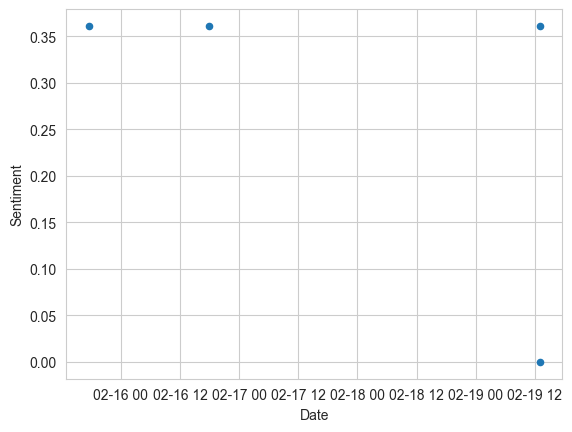

In [96]:
df[df['URL'] == urls[6]].plot(x='Date', y='Sentiment', kind='scatter')

In [98]:
df[df['URL'] == urls[6]]['Title']

8       Two skyscrapers joined by daring cantilevered ...
630     Two skyscrapers joined by daring cantilevered ...
1872    Two skyscrapers joined by daring cantilevered ...
1873                                  Bjarke Ingels Group
Name: Title, dtype: object

In [2]:
from afinn import Afinn
afinn = Afinn()
afinn.score(" China’s coast guard has triggered ‘panic’ in Taiwan. That’s only part of Beijing’s plan ")

-3.0